# 파생상품을 포함하여 손실을 최소화하는 최적화 포트폴리오 추천 알고리즘

## 배경, 이론적 기반, 원리에 대한 설명

### 배경

불확실한 시장 상황의 변동에 대응하기 위해 자산을 배분하여 포트폴리오를 구축하는 것은 이제 개인투자자들도 흔히 알고 있는 개념으로 자리잡았다.

그 중 가장 유명한 방법은 노벨상 수상자 Harry Markowitz의 효율적 투자선을 이용한 방법론이다. 포트폴리오의 기대 수익을 극대화함과 동시에, 수익률의 분산으로 측정되는 위험(Risk)을 최소화하는 것이 골자다.

그러나 해당 모델의 입력값(Input value)으로 사용되는 자산 수익률의 평균 및 공분산은 Noise가 있는 데이터에서 추정되기에, 정확하지 않다는 한계를 지닌다. 이러한 한계로 실무에서 이론을 그대로 사용하기는 어렵다.

이러한 오류를 완화하기 위하여 Bayesian estimation(Black and Litterman)을 이용하는 등의 접근이 시도된 바 있고, 2000년대 중반부터는 강건한 최적화(Robust Optimization)에 관련된 연구가 활발히 진행되었다.

### Robust Optimization

기존의 최적화 방법론과 달리, 강건한 최적화 문제가 가지는 특징 다음과 같다.

- 비확률적(Non-stochastic)
- 불확실성 집합(Uncertainty set)의 존재
- 최악의 결과(매개변수)를 예상할 경우, 불확실성 집합 내에서 최고의 선택을 찾음

그러나 이 또한 Markowitz의 모델과 비슷한 한계를 지닌다.

따라서 Portfolio의 보험적인 역할을 하는 European Option을 사용하여 불확실성 집합에 의해 포착되지 않는 최악의 사건에 대비하는 방법론을 채택했다. 

### 파생상품(옵션)을 포함하여 손실을 최소화하는 강건한 최적화 포트폴리오

쉽게 말하자면, 개별주식으로 이루어져 있는 포트폴리오에 개별주식 옵션을 포함하여 최악의 상황에서도 포트폴리오의 수익률을 방어하는 자산배분 알고리즘을 구현하고자 한다.

특히 전문투자자가 아닌, 일반투자자 또한 포트폴리오를 구축할 수 있도록 하는 다음의 장점을 가진다.

- 주식을 공매도 하지 않아도 됨
- 옵션 매도 포지션을 구축하지 않아도 됨(오로지 옵션 매수 포지션만 구축)
- 옵션에의 접근성이 떨어진다면, ELW로 대체 가능

#### Parameters 설명

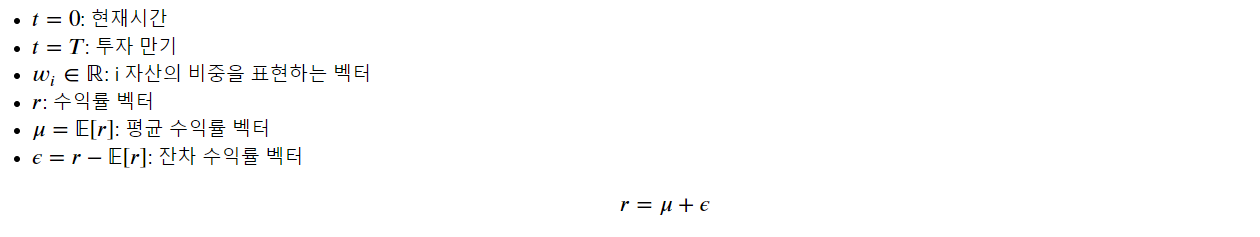

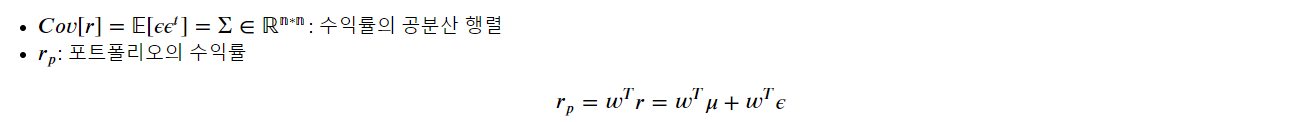

#### Markowitz의 최적화 방법론 도출
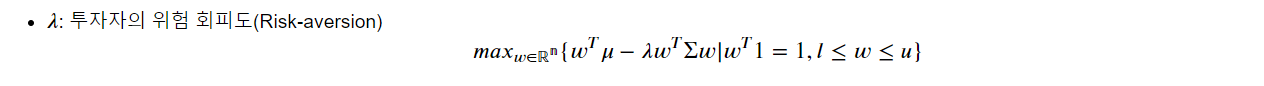

### (2) Uncertainty Set를 어떻게 정의할 것인가

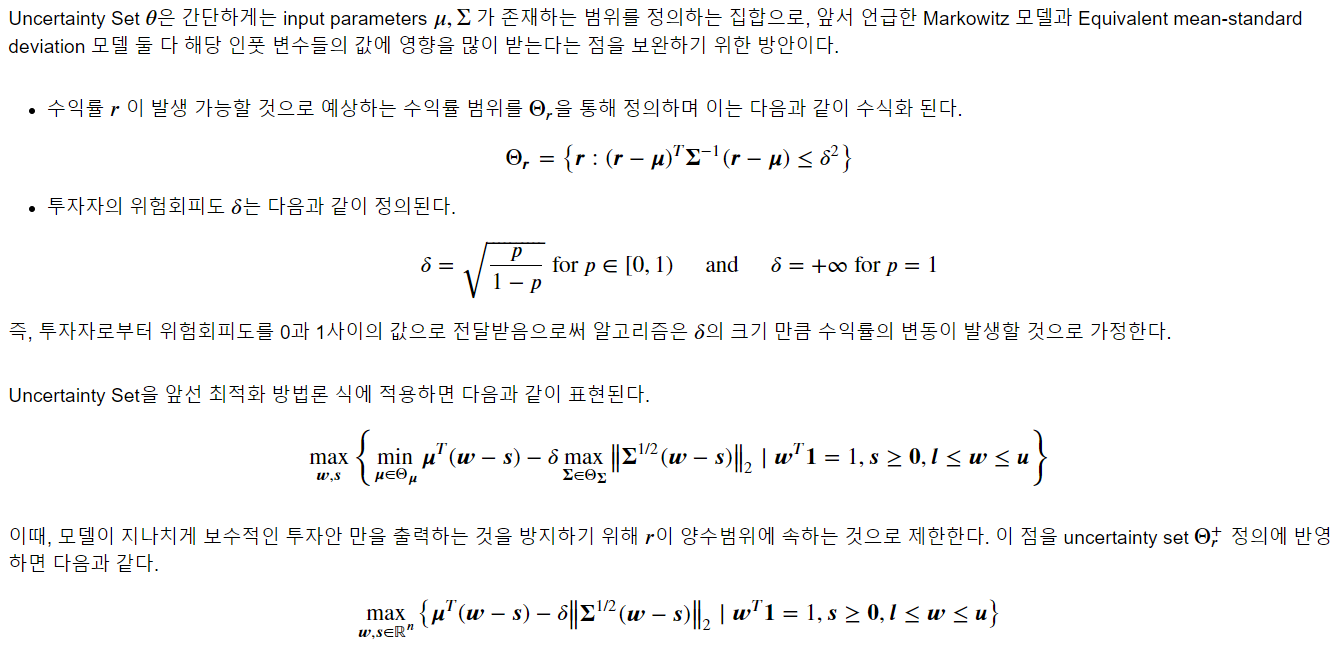

## 0. Modules Import

In [1]:
#필요한 패키지 호출
from pykrx import stock
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxpy as cvx
import progressbar
import warnings

## 1. Portfolio, Stock, Derivative 객체 생성

### 1-1. Stock

Stock class는 Ticker를 전달 받아 daily price, daily return을 저장하는 객체이다. 이때 reference_date와 reference_price는 포트폴리오를 구성하는 시점에서의 날짜 정보와 자산가격을 저장한다. 이는 파생상품 객체로 전달되어 연산에 이용된다.

다음은 Stock class의 특징이다.
* 이번에는 이용의 편의를 위하여 pykrx package를 사용하였다. 이후 사용자의 기호에따라 다양하게 변경이 가능하다.
* 포트폴리오에 편입할 모든 주식 종목은 같은 길이의 시계열을 담고 있어야하기에 start_date와 reference_date를 일치시켜주어야 한다.
* 지정된 시계열을 통해 covariance matrix가 계산되기 때문에 시계열 길이를 수정하는 방법으로 투자자는 본인의 투자 Term을 조정할 수 있다.

In [2]:
class Stock:
    def __init__(self, tickers, start_date='2020-01-04', reference_date='2022-01-04'):
        self.buffer = dict()
        self.register_buffer('type', 'stock')
        daily_price = fdr.DataReader(tickers, start=start_date, end=reference_date)

        daily_return = self.returns(df=daily_price)
        reference_date = reference_date
        reference_price = daily_price.iloc[-1]['Close']

        self.register_buffer('ticker', tickers)
        self.register_buffer('name', tickers)
        self.register_buffer('daily_return', daily_return)
        self.register_buffer('reference_date', reference_date)
        self.register_buffer('reference_price', reference_price)

    def register_buffer(self, name: str, buffer):
        self.buffer[name] = buffer

    @staticmethod
    def returns(df: pd.DataFrame):
        return np.array(df['Close'].pct_change()[1:])

    def view_parameters(self):
        for key, value in self.buffer.items():
            print('{}: {}'.format(key, value))

### 1-2. Derivative

Derivative class는 European Option을 생성하는 객체이다. 이때 전달받는 인자로 Stock 객체의 base_stock과 콜/풋을 구분하는 category, 옵션의 이름, 행사가격, 프리미엄을 가진다.

다음은 Derivative class의 특징이다.
* 옵션의 경우 지수 옵션을 제외하고 국내 시장에서 유동성이 적은 실정이다. 따라서 투자자는 본인의 선택에 따라 ELW 상품으로 이를 대신할 수 있다. 이번 예시에서 KRX 예선데이터의 ELW 데이터를 활용하였다.
* 옵션의 수익률을 연산하기 전에 옵션 수익률은 기초자산 수익률의 함수임을 이해해야한다.



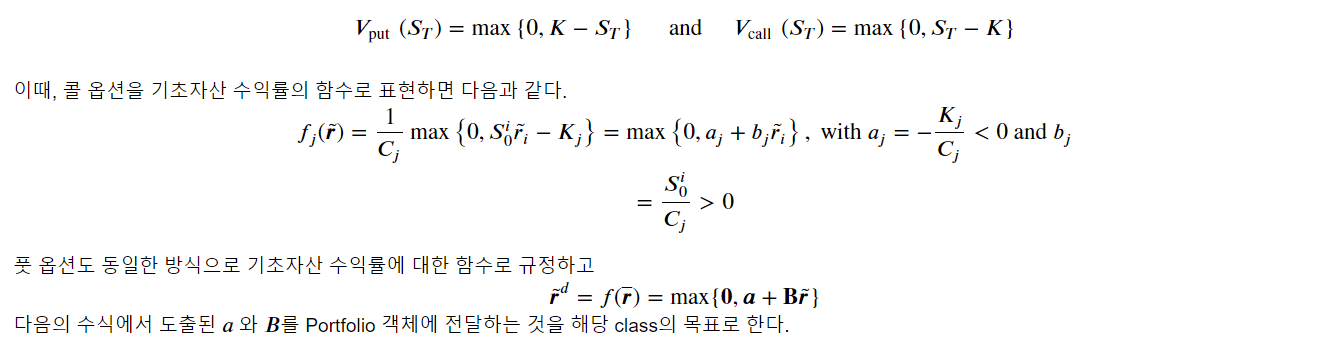

In [3]:
class Derivative:
    def __init__(self, base_stock, category, name, strike_price, premium):
        self.buffer = dict()
        self.register_buffer('type', 'derivative')
        self.register_buffer('base_ticker', base_stock.buffer['ticker'])
        self.register_buffer('base_stock', stock.get_market_ticker_name(base_stock.buffer['ticker']))
        self.register_buffer('category', category)
        self.register_buffer('name', name)
        self.register_buffer('S0', base_stock.buffer['reference_price'])
        self.register_buffer('K', strike_price)
        self.register_buffer('cost', premium)

        self.returns()

    def returns(self):
        if self.buffer['category'] == '콜' or 'call':
            self.buffer['a'] = -(self.buffer['K'] / self.buffer['cost'])
            self.buffer['B'] = (self.buffer['S0'] / self.buffer['cost'])
        elif self.buffer['category'] == '풋' or 'put':
            self.buffer['a'] = (self.buffer['K'] / self.buffer['cost'])
            self.buffer['B'] = -(self.buffer['S0'] / self.buffer['cost'])
        else:
            raise Exception('Type error!')

    def register_buffer(self, name: str, buffer):
        self.buffer[name] = buffer

    def view_parameters(self):
        for key, value in self.buffer.items():
            print('{}: {}'.format(key, value))

### 1-3. Portfolio
Portfolio class는 위에서 정의한 Stock, Derivative class들을 add하여 포트폴리오 풀을 형성하고 최적화 알고리즘을 통해 강건한 포트폴리오 자산배분을 제시한다.

위에서 소개한 최적화 식에서 옵션을 포함한 최적화 모형으로 다시 정리한다면 다음의 수식으로 정리된다.


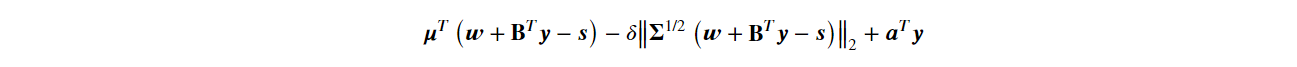

모든 증권(개별주식, 옵션) 비중의 합이 1이 되게 함으로써 레버리지를 제한하였다. 투자자는 개인의 의사에 따라 제한을 완화하는 식의 변형이 가능하다.

다음은 Portfolio class의 함수에 대한 간략한 설명이다.
- add : 주식, 파생상품 추가
- fit : 최적 포트폴리오 도출
- set_risk_aversion : 위험회피성향 설정
- view_parameter : 매개변수 출력

In [4]:
class Portfolio:
    def __init__(self, risk_aversion, securities_storage=False):
        """
        n: The number of stock
        m: The number of derivatives
        L: length of time-series
        buffer: a dictionary that stores all the data needed for the operation
        """

        self.buffer = dict()
        # stock daily price dataframe (n x 1)
        self.reference_price = np.array([])
        # stock daily return matrix (n x L-1)
        self.stock_return = np.array([])
        # stock daily return covariance matrix (n x n)
        self.sigma = np.array([])
        # stock return mean matrix (n x 1)
        self.mu = np.array([])
        # stock optimal weights matrix (n x 1)
        self.weight_stock = np.array([])
        # derivative optimal weights matrix (m x 1)
        self.weight_derivative = np.array([])
        # derivative, base_stock mapping & parameter matrix
        self.B = np.array([])
        # derivative return function parameter matrix
        self.a = np.array([])
        # variable matrix for optimization (m x 1)
        self.y = np.array([])
        # variable matrix for optimization (n x 1)
        self.s = np.array([])
        # risk-aversion 0<=p<=1
        self.p = risk_aversion
        # adjusted risk aversion
        self.xi = np.sqrt(self.p / (1 - self.p))

        self.ticker_list = list()
        self.derivative_list = list()
        self.n = 0
        self.m = 0

        if securities_storage:
            self.stock_storage = list()
            self.derivative_storage = list()


    def add(self, security, print_inserting_info=False):
        try:
            if security.buffer['type'] == 'stock':
                if self.reference_price.size != 0 and self.stock_return.size != 0:
                    self.reference_price = np.vstack((self.reference_price, security.buffer['reference_price']))
                    self.stock_return = np.vstack((self.stock_return, security.buffer['daily_return']))
                else:
                    self.reference_price = np.append(self.reference_price, security.buffer['reference_price'])
                    self.stock_return = np.append(self.stock_return, security.buffer['daily_return'])
                self.ticker_list.append(security.buffer['ticker'])

                try:
                    if self.B.size != 0:
                        self.B = np.hstack((self.B, np.zeros((len(self.derivative_list), 1))))
                    else:
                        self.B = np.zeros((self.m, self.n))
                except Exception as e:
                    print(e)

                self.n += 1
                self.stock_storage.append(security)

            elif security.buffer['type'] == 'derivative':
                self.m += 1
                self.derivative_list.append(security.buffer['name'])
                if self.a.size != 0 and self.B.size != 0:
                    self.a = np.vstack((self.a, security.buffer['a']))
                    self.B = np.vstack((self.B, np.zeros((1, len(self.ticker_list)))))
                else:
                    self.a = np.append(self.a, security.buffer['a'])
                    self.B = np.zeros((self.m, self.n))

                tmp = self.ticker_list.index(security.buffer['base_ticker'])
                row = self.B.shape[0] - 1
                self.B[row, tmp] = security.buffer['B']

                self.derivative_storage.append(security)
            if print_inserting_info:
                print("{} {} is successfully inserted".format(security.buffer['type'], security.buffer['name']))
        except Exception as e:
            print(e)

    def fit(self, detail=False):
        self.buffer['stock_price'] = self.reference_price
        self.buffer['stock_return'] = self.stock_return
        self.mu = np.mean(self.buffer['stock_return'], axis=1).T
        self.sigma = np.cov(self.buffer['stock_return'])
        self.buffer['mu'] = self.mu
        self.buffer['sigma'] = self.sigma
        self.buffer['B'] = self.B
        self.buffer['a'] = self.a
        self.buffer['xi'] = self.xi

        n = self.buffer['mu'].shape[0]
        m = self.buffer['B'].shape[0]

        w = cvx.Variable((n, 1))
        wd = cvx.Variable((m, 1))
        y = cvx.Variable((m, 1))
        s = cvx.Variable((n, 1))

        w_one = np.ones((n, 1))
        wd_one = np.ones((m, 1))

        st1 = self.buffer['mu'].T @ (w + self.buffer['B'].T @ y - s)
        st2 = self.buffer['xi'] * cvx.norm2(np.sqrt(self.buffer['sigma']) @ (w + self.buffer['B'].T @ y - s))
        st3 = self.buffer['a'].T @ y

        try:
            obj = cvx.Maximize(st1 - st2 + st3)
            constraints = [y <= wd, -y <= 0, -s <= 0, w_one.T @ w + wd_one.T @ wd == 1, -w <= 0]
            prob = cvx.Problem(obj, constraints)
            result = prob.solve(solver='SCS')

        except Exception as e:
            print(e)
            result = None

        self.weight_stock = w.value
        self.weight_derivative = wd.value
        self.y = y.value
        self.s = s.value

        if detail:
            print("stock allocation: \n{} \nderivatives allocation:\n{}".format(self.weight_stock, self.weight_derivative))

        return result

    def set_risk_aversion(self, risk_aversion):
        self.p = risk_aversion
        self.xi = np.sqrt(self.p / (1 - self.p))
        self.buffer['xi'] = self.xi

    def view_parameters(self):
        for key, value in self.buffer.items():
            try:
                print('{}: {}'.format(key, value.shape))

            except Exception as e:
                print('{}: {}'.format(key, value))

## 2. 데이터 가져오기

In [5]:
# 필요 데이터 로딩
elw = pd.read_csv('[ELW]일별 매매정보(주문번호-1301-18)_202201.csv', encoding='cp949')
elw = elw.append(pd.read_csv('[ELW]일별 매매정보(주문번호-1301-18)_202202.csv', encoding='cp949'))
elw = elw.append(pd.read_csv('[ELW]일별 매매정보(주문번호-1301-18)_202203.csv', encoding='cp949'))

# 임의의 Ticker 집합
ticker_list1 = ['005930', '003490', '066570']
ticker_list2 = ['005930', '003490', '066570', '000660', '005380', '017670', '051910', '001040']

In [6]:
# elw 필요 데이터 추출
elw = elw[['거래일자', '종목명', '종가', '행사가격', '콜/풋', '기초자산명']]

# 예시 사용 기업 출력
for i in ticker_list1:
    print(stock.get_market_ticker_name(i), end=' ')

삼성전자 대한항공 LG전자 

In [7]:
# 포트폴리오 객체 생성과 사용자 위험 회피도 인자 전달
port = Portfolio(risk_aversion=0.1, securities_storage=True)

# 포트폴리오 구성 자산 입력
for i in range(len(ticker_list1)):
    tmp = Stock(ticker_list1[i])
    port.add(tmp, print_inserting_info=True)
    stock_name = stock.get_market_ticker_name(ticker_list1[i])
    df = elw[(elw['기초자산명']==stock_name)&(elw['거래일자']==20220104)&(elw['종가']!=0)]

    for j in range(len(df.index)):
        tmp_d = Derivative(tmp, df['콜/풋'].iloc[j], df['종목명'].iloc[j], df['행사가격'].iloc[j], df['종가'].iloc[j])
        port.add(tmp_d, print_inserting_info=True)

stock 005930 is successfully inserted
derivative 신한G141삼성전자콜 is successfully inserted
derivative 신한G142삼성전자콜 is successfully inserted
derivative 신한G197삼성전자콜 is successfully inserted
derivative 신한G143삼성전자콜 is successfully inserted
derivative 신한G199삼성전자콜 is successfully inserted
derivative 신한G084삼성전자풋 is successfully inserted
derivative 신한G144삼성전자풋 is successfully inserted
derivative 신한G145삼성전자풋 is successfully inserted
derivative 신한G200삼성전자풋 is successfully inserted
derivative 신한G146삼성전자풋 is successfully inserted
derivative 신한G202삼성전자풋 is successfully inserted
derivative 신한G203삼성전자풋 is successfully inserted
derivative 신한G205삼성전자풋 is successfully inserted
derivative 미래GK69삼성전자콜 is successfully inserted
derivative 미래GN14삼성전자콜 is successfully inserted
derivative 미래GQ46삼성전자콜 is successfully inserted
derivative 미래GK70삼성전자콜 is successfully inserted
derivative 미래GN15삼성전자콜 is successfully inserted
derivative 미래GQ47삼성전자콜 is successfully inserted
derivative 미래G574삼성전자콜 is successfully inserted
de

## 3. 포트폴리오 최적화

다음의 예시는 3개의 주식 종목을 포트폴리오에 편입하고 이를 기초자산으로 하는 거래 가능한 모든 옵션을 편입하였다.
투자자는 자신이 고려하고 있는 옵션 종목 몇가지 만을 전달하여 포트폴리오를 설계할 수 있을 것이다.

이번 예시의 경우, 다양한 행사가격과 프리미엄을 가진 이백 여개의 옵션을 포함하고 있기 때문에 매우 복잡한 PnL 구조를 형성하였다. 또한 옵션(ELW)가 없는 대한항공이 포함됨에도 계산상의 오류가 없는 모습을 확인하였다.

사용자는 개인의 판단에 따라 다양한 최적화 알고리즘을 사용할 수 있다. 이번의 예시에서는 SCS Solver을 사용하였다.

In [8]:
port.fit()

print('stock ratio: {}'.format(np.sum(port.weight_stock)))
print('derivative ratio: {}'.format(np.sum(port.weight_derivative)))

stock ratio: 0.8412408279518598
derivative ratio: 0.1587591720481092


In [9]:
index = [stock.get_market_ticker_name(i) for i in ticker_list1]
pd.DataFrame({'Optimal_stock_allocation': np.concatenate(port.weight_stock)}, index=index)

,Optimal_stock_allocation
삼성전자,0.422680
대한항공,0.258924
LG전자,0.159637


In [10]:
pd.DataFrame({'Optimal_ELW_allocation': np.concatenate(port.weight_derivative[:5])}, index=port.derivative_list[:5])

,Optimal_ELW_allocation
신한G141삼성전자콜,0.000555
신한G142삼성전자콜,0.000554
신한G197삼성전자콜,0.000553
신한G143삼성전자콜,0.000556
신한G199삼성전자콜,0.000554


## 4. 최적 포트폴리오 시각화

이번에는 동일한 포트폴리오에서 위험회피도를 다양하게 설정하여 기초자산, 콜옵션, 풋옵션의 비중을 스스로 조정하는 모습을 확인해보자.

In [11]:
warnings.filterwarnings(action='ignore')
stock_ratio = list()
call_ratio = list()
put_ratio = list()

bar = progressbar.ProgressBar()
p = np.round([i/10 for i in np.arange(0,10,0.5)],2)

for i in bar(range(len(p))):
    call = 0
    put = 0
    port.set_risk_aversion(p[i])
    port.fit()
    stock_ratio.append(np.sum(port.weight_stock))

    for j in range(len(port.derivative_storage)):
        category = port.derivative_storage[j].buffer['category']
        if category == '콜':
            call += port.weight_derivative[j]
        else:
            put += port.weight_derivative[j]
    call_ratio.append(call)
    put_ratio.append(put)

call_ratio = np.concatenate(call_ratio)
put_ratio = np.concatenate(put_ratio)

100% |########################################################################|


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


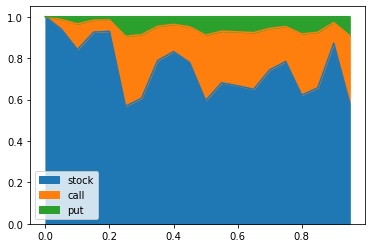

In [12]:
%matplotlib inline
warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumGothic')

aa = pd.DataFrame({
    'stock': stock_ratio,
    'call': call_ratio,
    'put': put_ratio}, index=[p/100 for p in range(0,100,5)])
aa = aa.round(5)
aa.plot.area()

## 참고. 해당 최적화 알고리즘은 옵션 투자를 강제하지 않는다.

임의의 주식 종목을 여러개 포함한 경우의 최적 포트폴리오 살펴보자.
다음의 경우는 worst-case의 수익률을 최대하는 solution으로 기초자산으로만 이루어진 포트폴리오를 제시한다.
이는 기초자산간의 공분산 행렬의 영향으로 볼 수 있다.

In [13]:
# 포트폴리오 객체 생성과 사용자 위험 회피도 인자 전달
port = Portfolio(risk_aversion=0.1, securities_storage=True)

# 포트폴리오 구성 자산 입력
for i in range(len(ticker_list2)):
    tmp = Stock(ticker_list2[i])
    port.add(tmp)
    stock_name = stock.get_market_ticker_name(ticker_list2[i])
    df = elw[(elw['기초자산명']==stock_name)&(elw['거래일자']==20220104)&(elw['종가']!=0)]

    for j in range(len(df.index)):
        tmp_d = Derivative(tmp, df['콜/풋'].iloc[j], df['종목명'].iloc[j], df['행사가격'].iloc[j], df['종가'].iloc[j])
        port.add(tmp_d)

In [14]:
port.fit()
print('stock ratio: {}'.format(np.round(np.sum(port.weight_stock)),4))
print('derivative ratio: {}'.format(np.round(np.sum(port.weight_derivative)),4))

stock ratio: 1.0
derivative ratio: -0.0


In [15]:
index = [stock.get_market_ticker_name(i) for i in ticker_list2]
pd.DataFrame({'Optimal_stock_allocation': np.round(np.concatenate(port.weight_stock),4)}, index=index)

,Optimal_stock_allocation
삼성전자,0.0000
대한항공,0.4654
LG전자,0.1561
SK하이닉스,0.0000
현대차,0.0993
SK텔레콤,0.0000
LG화학,0.2792
CJ,-0.0000
